In [1]:
from torchvision import models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import pickle as pkl
from tqdm import tqdm

In [2]:
def M_loss(real, fake):
    m_loss = torch.mean(((real - fake)**2))
    return m_loss

<built-in method type of Tensor object at 0x0000023D37DCB180>


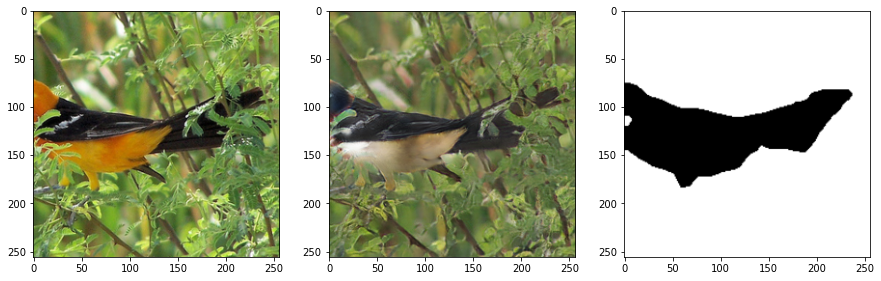

<built-in method type of Tensor object at 0x0000023D0008F9F0>


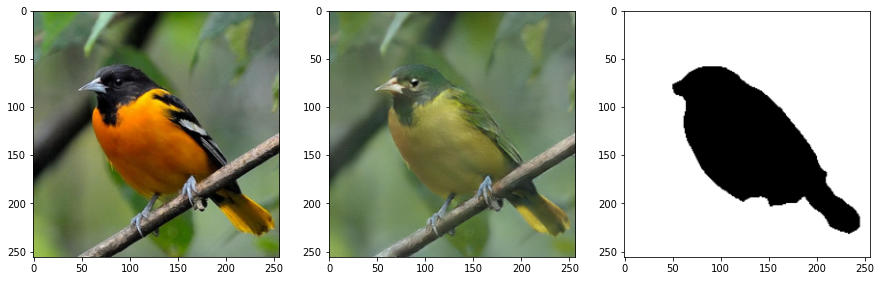

<built-in method type of Tensor object at 0x0000023D00182130>


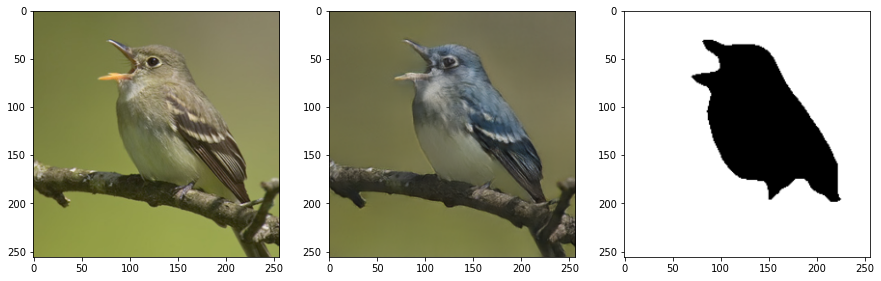

<built-in method type of Tensor object at 0x0000023D0029C450>


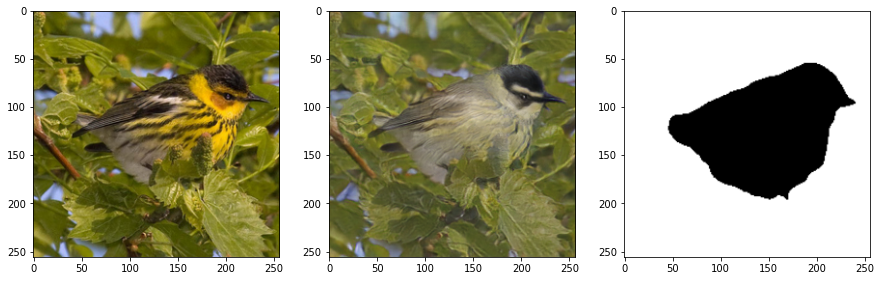

<built-in method type of Tensor object at 0x0000023D0254A6D0>


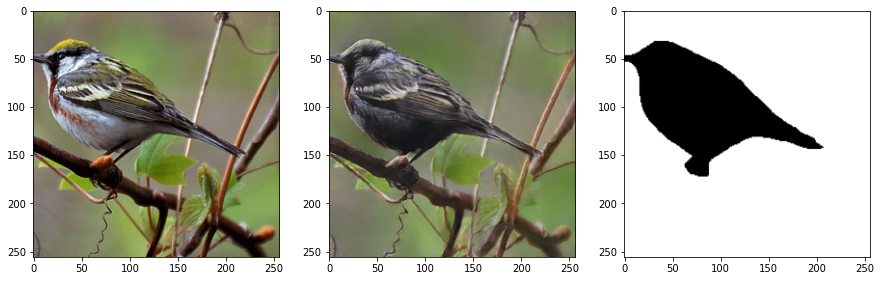

<built-in method type of Tensor object at 0x0000023D48C104A0>


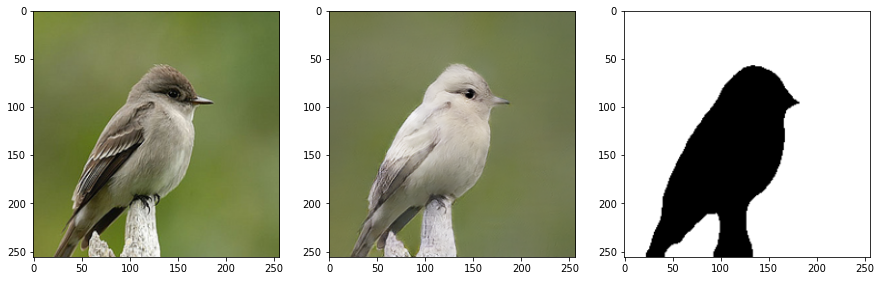

In [3]:
def read_image_torch(img_name):
    
    img = np.array(Image.open(os.path.join('data', img_name)))
    img = torch.tensor(img)
    img = torch.permute(img,(2, 0, 1))
    img = torch.reshape(img, (1, img.size()[0], img.size()[1], img.size()[2]))
    
    return img

def segment_bird(real_batch, fake_batch):
    
    real_batch = real_batch / 255.
    fake_batch = fake_batch / 255.
    
    fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
    trf = T.Compose([T.Resize(224),
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])
                    ])
    trf_back = T.Compose([T.Resize(256)])

    trf_real_batch = trf(real_batch.float())

    out = fcn(trf_real_batch)['out']

    out = torch.argmax(out, dim=1, keepdim=True)

    out = (out == 3).float()
    
    out = trf_back(out)
    
    out = (1 - out).float()
    
    return out

## Create scoring method

In [4]:
def read_image_torch(img_name, folder_name):
    
    img = np.array(Image.open(os.path.join('fcn_eval', folder_name, img_name)))
    img = torch.tensor(img)
    img = torch.permute(img,(2, 0, 1))
    img = torch.reshape(img, (1, img.size()[0], img.size()[1], img.size()[2]))
    
    return img

In [25]:
imgs_suffix = [i for i in range(0, 1000)]
scores = []

for img_suffix in tqdm(imgs_suffix):
    real_batch, fake_batch = [], []
    
    real_batch.append(read_image_torch('real_r' + str(img_suffix) + '.png'))
    fake_batch.append(read_image_torch('fake_s' + str(img_suffix) + '.png'))
    
    real_batch = torch.cat(real_batch, dim=0)
    fake_batch = torch.cat(fake_batch, dim=0)
    
    mask_batch = segment_bird(real_batch, fake_batch)
    
    masked_reals = torch.mul(real_batch, mask_batch)
    masked_fakes = torch.mul(fake_batch, mask_batch)
    
    # calc score
    
    scores.append(M_loss(masked_reals, masked_fakes))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [38:53<00:00,  2.33s/it]


## Visualise images

In [23]:
imgs_suffix = [i for i in range(420, 430)]
scores_orig = []
scores_mask = []
scores_abs = []

real_batch, fake_batch_orig, fake_batch_mask, fake_batch_mask_abs = [], [], [], []

for img_suffix in tqdm(imgs_suffix):
    
    real_batch.append(read_image_torch('real_r' + str(img_suffix) + '.png', folder_name = 'original/orig'))
    
    fake_batch_orig.append(read_image_torch('fake_s' + str(img_suffix) + '.png', folder_name = 'original/orig'))
    # mask using original loss 100 epochs trained
    fake_batch_mask.append(read_image_torch('fake_s' + str(img_suffix) + '.png', folder_name = 'mask_100/100'))
    # mask using new loss 100 epochs trained
    fake_batch_mask_abs.append(read_image_torch('fake_s' + str(img_suffix) + '.png', folder_name = 'mask_changed_loss/100'))
    
real_batch = torch.cat(real_batch, dim=0)

fake_batch_orig = torch.cat(fake_batch_orig, dim=0)
fake_batch_mask = torch.cat(fake_batch_mask, dim=0)
fake_batch_mask_abs = torch.cat(fake_batch_mask_abs, dim=0)

mask_batch = segment_bird(real_batch, fake_batch)

masked_reals = torch.mul(real_batch, mask_batch)
masked_fake_batch_orig = torch.mul(fake_batch_orig, mask_batch)
masked_fake_batch_mask = torch.mul(fake_batch_mask, mask_batch)
masked_fake_batch_mask_abs = torch.mul(fake_batch_mask_abs, mask_batch)
    
# calc score
    
scores_orig.append(M_loss(masked_reals, masked_fake_batch_orig))
scores_mask.append(M_loss(masked_reals, masked_fake_batch_mask))
scores_abs.append(M_loss(masked_reals, masked_fake_batch_mask_abs))

100%|█████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.49it/s]


457.82242 457.47656 225.33171


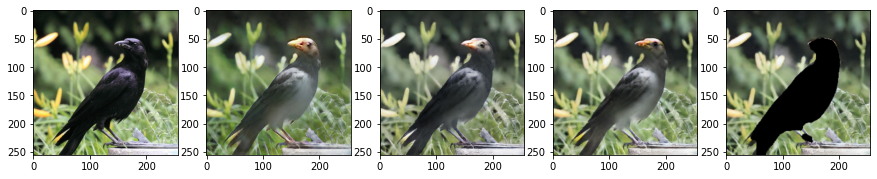

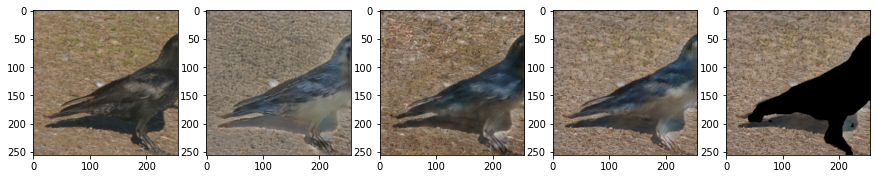

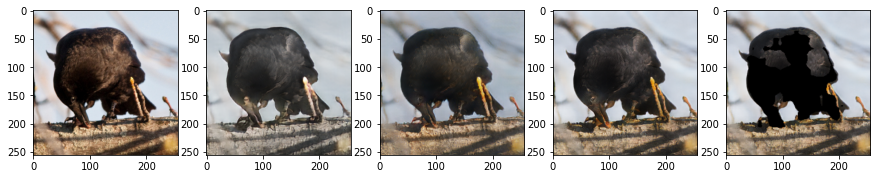

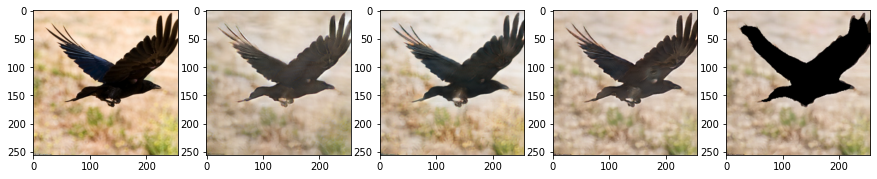

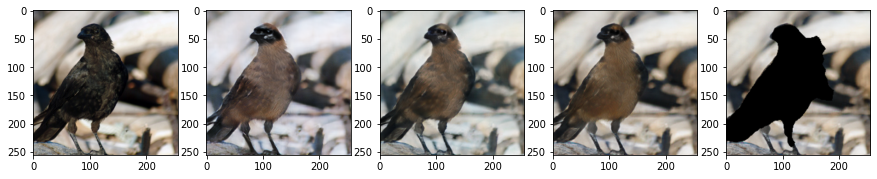

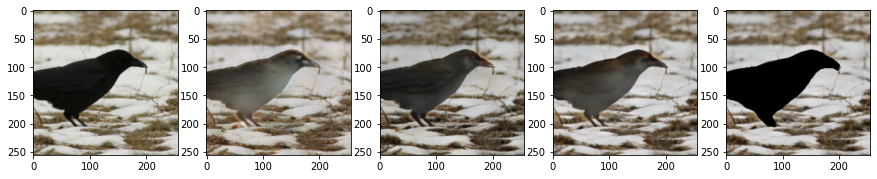

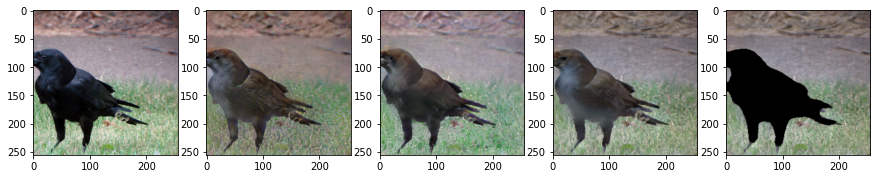

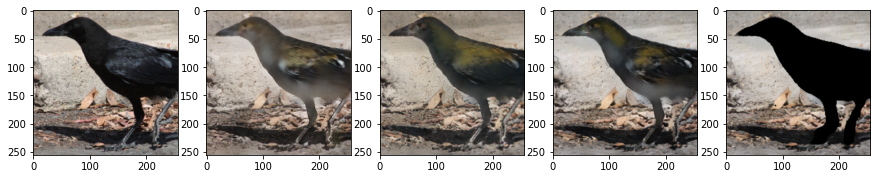

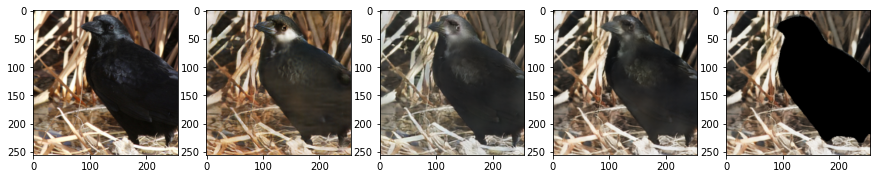

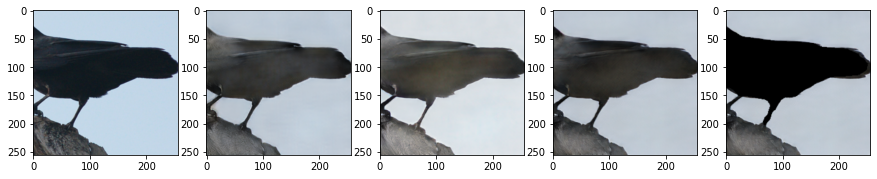

In [24]:
print(np.array(scores_orig).mean(), np.array(scores_mask).mean(), np.array(scores_abs).mean())

for ind in range(0, len(imgs_suffix)):
    f, axarr = plt.subplots(1, 5, figsize=(15, 5))
    #print(real_batch[ind].permute(1, 2, 0).type)
    axarr[0].imshow(real_batch[ind].permute(1, 2, 0), cmap='gray')
    #axarr[1].imshow(masked_reals[ind].permute(1, 2, 0).long(), cmap='gray')
    axarr[1].imshow(fake_batch_orig[ind].permute(1, 2, 0).long(), cmap='gray')
    axarr[2].imshow(fake_batch_mask[ind].permute(1, 2, 0).long(), cmap='gray')
    axarr[3].imshow(fake_batch_mask_abs[ind].permute(1, 2, 0).long(), cmap='gray')
    axarr[4].imshow(masked_fake_batch_mask_abs[ind].permute(1, 2, 0).long(), cmap='gray')
    plt.show()

In [15]:
# mean score original
# sum(scores) / len(scores)

tensor(538.9589)

In [19]:
# mean mask 100
sum(scores) / len(scores)

tensor(565.7678)

In [23]:
# mean mask 150
sum(scores) / len(scores)

tensor(508.5740)

In [27]:
# mean mask with new loss
sum(scores) / len(scores)

tensor(267.1133)

In [45]:
# scores of only 10 images
np.array(scores_orig).mean(), np.array(scores_mask).mean(), np.array(scores_abs).mean()

(505.5325, 492.31998, 178.42668)